In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [2]:
# define functions
def LinearFunc(t, a, b):
    return a * t + b

def AiryFunc(t, B, A, F, T, t0):
    return B + A / ( 1 + F * (np.sin( (np.pi/T)*(t-t0) ))**2 )

def Calib(t, T, t0):
    return (10.0/T)*(t - t0)

def Calib_err(t, T, t0, T_err2, t0_err2):
    return np.sqrt( ((10.0/(T**2))*(t - t0))**2 * T_err2 + ((10.0/T)**2 * t0_err2 ) )

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

## Calibration with the Fabry-Perot

In [18]:
# Importing and formatting data

# Reading Files
ramp0 = pd.read_csv("New Data/Calibration/A0030CH1.CSV")
FP0 = pd.read_csv("New Data/Calibration/A0030CH2.CSV")

#Seperating Data
RawRampTime = pd.DataFrame(ramp0, columns= ['col 1'])
RawRamp = pd.DataFrame(ramp0, columns= ['col 2'])
RawFPTime = pd.DataFrame(FP0, columns= ['col 1'])
RawFP = pd.DataFrame(FP0, columns= ['col 2'])

#Formatting Data
RampTime = np.resize(RawRampTime,(4000,1))
Ramp = np.resize(RawRamp,(4000,1))
FabryTime = np.resize(RawFPTime,(4000,1))
Fabry = np.resize(RawFP,(4000,1))

t_start = 0.002
t_end = 0.006

#pulling out important indices
j = 0
for i in FabryTime: 
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    if i == 0.0027:
        tf1 = j
    if i == 0.004:
        tf2 = j
    j += 1

#Resizing and cutting
BackgroundT_pts = FabryTime[tf1:tf2,0]
BackgroundFabry = Fabry[tf1:tf2,0]

RampTime = RampTime[t1:t2,0]
Ramp = Ramp[t1:t2,0]
FabryTime = FabryTime[t1:t2,0]
Fabry = Fabry[t1:t2,0]

#DoubleChecking Times
TimeDiff = RampTime - FabryTime

for i in TimeDiff:
    if i != 0:
        print("ERROR")
        
t_pts = FabryTime

#plt.plot(t_pts, Fabry)
#plt.plot(t_pts, Ramp*(30))
#plt.plot(BackgroundT_pts, BackgroundFabry)
#plt.minorticks_on()

In [19]:
# Finding the error for our fit
BackgroundGuess = [0, 0.02]

BackParam, BackParam_cov = curve_fit(LinearFunc, BackgroundT_pts, BackgroundFabry, BackgroundGuess, maxfev=150000)

FPV_error = np.sqrt( sum( (BackgroundFabry - LinearFunc(BackgroundT_pts, *BackParam))**2 ) / (np.size(BackgroundT_pts) - 2) )
FPV_errorArray = FPV_error * np.linspace(1,1,np.size(t_pts))
print("")
print("Error in the voltage for the Fabry-Perot = (+/-) " + str(FPV_error) + " V")


Error in the voltage for the Fabry-Perot = (+/-) 0.020845252332506753 V


0: Background
1: Amplitude
2: Finness
3: Period
4: t0

0 = -0.03959364787757993 +/- 0.004812474000947989
1 = 6.376664509860483 +/- 0.04127978972456335
2 = 585.7529072493786 +/- 11.249888504537891
3 = 0.0021729070103158102 +/- 3.702672557397168e-07
4 = 0.0024331756086676567 +/- 2.618200464649268e-07

Chi Squared = 175718.5024646089
Reduced Chi Squared = 88.16783866764119


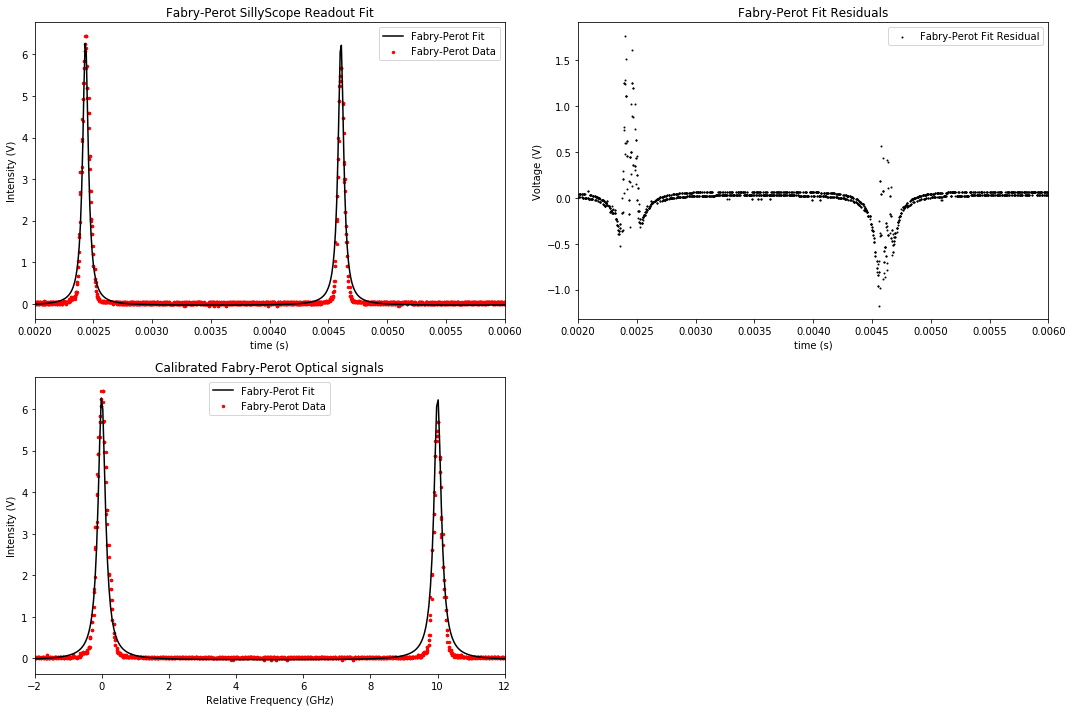

In [20]:
# Fitting, plotting and calibration
FPGuess = [0, 6, 550, .0025, .0024]

FPParam, FPParam_cov = curve_fit(AiryFunc, t_pts, Fabry, FPGuess, sigma= FPV_errorArray, maxfev=150000)

print("0: Background")
print("1: Amplitude")
print("2: Finness")
print("3: Period")
print("4: t0")
print("")

i = 0
while i < 5:
    print(str(i) + " = " + str(FPParam[i]) + " +/- " + str(np.sqrt(FPParam_cov[i,i])) )
    i += 1
    
#FP_Period = FPParam[3]
#FP_Period_Err = np.sqrt(FPParam_cov[3,3])

print("")
FP_RCS = RdChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error, 5)
FP_CS = ChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error)

print("Chi Squared = " + str(FP_CS))
print("Reduced Chi Squared = " + str(FP_RCS))

# I'm not sure if this matters but this was driven at 114.0 Hz at an amplitude of 112.0 mV
#RelativeFreq = (10.0/FPParam[3])*(t_pts - FPParam[4])
#RelativeFreq_err = np.sqrt( ((10.0/(FPParam[3])**2)*(t_pts - FPParam[4]))**2 * FPParam_cov[3,3]
#                           + ((10.0/FPParam[3])**2 * FPParam_cov[4,4] ) )

RelativeFreq = Calib(t_pts, FPParam[3], FPParam[4])
RelativeFreq_err = Calib_err(t_pts, FPParam[3], FPParam[4], FPParam_cov[3,3], FPParam_cov[4,4])

fig = plt.figure(figsize=(15,10))
FPplt = fig.add_subplot(2,2,1)
#FPplt.scatter(RelativeFreq, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.scatter(t_pts, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.plot(t_pts, AiryFunc(t_pts, *FPParam), label='Fabry-Perot Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(t_start,t_end)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("time (s)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Fabry-Perot SillyScope Readout Fit')
FPplt.legend();

FPResidplt = fig.add_subplot(2,2,2)
FPResidplt.scatter(t_pts, (Fabry - AiryFunc(t_pts, *FPParam)), label='Fabry-Perot Fit Residual', color='black', s=1)
FPResidplt.set_xlim(t_start,t_end)
FPResidplt.set_xlabel("time (s)")
FPResidplt.set_ylabel('Voltage (V)')
FPResidplt.set_title('Fabry-Perot Fit Residuals')
FPResidplt.legend();

FPGuess2 = [0, 6, 550, 10, 0]
FPParam2, FPParam2_cov = curve_fit(AiryFunc, RelativeFreq, Fabry, FPGuess2, sigma= FPV_errorArray, maxfev=150000)

FPplt = fig.add_subplot(2,2,3)
FPplt.scatter(RelativeFreq, Fabry, label='Fabry-Perot Data', color='red', s=6)
#FPplt.scatter(t_pts, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.plot(RelativeFreq, AiryFunc(RelativeFreq, *FPParam2), label='Fabry-Perot Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(-2,12)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("Relative Frequency (GHz)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Calibrated Fabry-Perot Optical signals')
FPplt.legend();

fig.tight_layout()

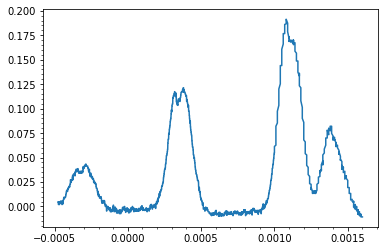

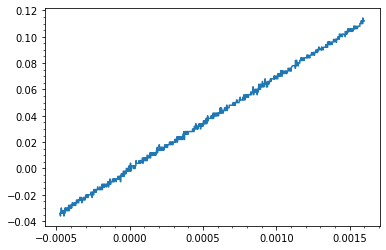

Pram(0): -0.0003087587057972757 +/- 1.4549229147201317e-06
Pram(1): 0.041456271563877226 +/- 0.0007197472161438613
Pram(2): 0.00010273593874507527 +/- 2.0898515596876686e-06
Pram(3): 0.00035737579422724387 +/- 4.6792259911923977e-07
Pram(4): 0.12521549385831943 +/- 0.0007350087612511509
Pram(5): 9.76329665293977e-05 +/- 6.617424823615033e-07
Pram(6): 0.0011034899738805854 +/- 3.119729707463157e-07
Pram(7): 0.1896900696967174 +/- 0.0007406858885544736
Pram(8): 9.734586837615638e-05 +/- 4.520514501786147e-07
Pram(9): 0.0013926666659754034 +/- 7.169250598041263e-07
Pram(10): 0.07780851258400669 +/- 0.0007848109890814667
Pram(11): 8.647194371809937e-05 +/- 1.0356100619385903e-06


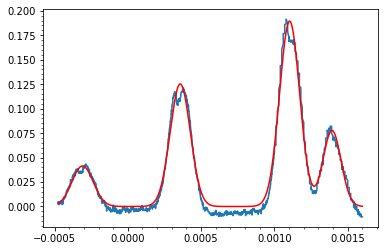

In [21]:
data =  pd.read_csv("A0001CH1.CSV")
data = np.array(data)
x,y = np.split(data, [-1], 1) # Divide into x and y for curve fitting
x.flatten() 
y.flatten()
x = np.hstack(x) # Fix stupid 2d array crap
y = np.hstack(y)

x = x[963:3036]
y = y[963:3036]
rampdata = pd.read_csv("A0001CH2.CSV")
rampdata = np.array(rampdata)
rampx, rampy = np.split(rampdata, [-1], 1)
rampx.flatten()
rampy.flatten()
rampx = np.hstack(rampx)
rampy = np.hstack(rampy)
rampx = rampx[963:3036]
rampy = rampy[963:3036]
y = y + 0.333333333*rampy + 0.01
plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.minorticks_on()
plt.show()


def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

guess = [-0.00030, 0.05000, 0.00020, 0.00030, 0.15000, 0.00020, 0.00110, 0.21000, 0.00020, 0.00135, 0.08000, 0.00020]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, x, y, p0=guess, maxfev=100000)
#print(popt)
fit = func(x, *popt)
#chi2 = np.sum((y - fit)**2/y)
#print(chi2)

i = 0
while i < 12:
    print("Pram(" + str(i) + "): " + str(popt[i]) + " +/- " + str(np.sqrt(pcov[i,i])) )
    i += 1

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()

Y-error = (+/-) 0.0018415668650813705


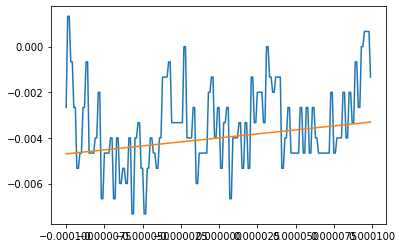

In [67]:
# Find flat '0' segments "manually"
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == -0.0001:
        t1 = j
    if i == 0.0001:
        t2 = j
    j += 1
    
x_flat = x[t1:t2]
y_flat = y[t1:t2]

Back_guess = [7,-.004]

def linfunc(x_pts, a, b):
    return a * x_pts + b

Back_popt, Back_pcov = optimize.curve_fit(linfunc, x_flat, y_flat, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_flat - linfunc(x_flat, *Back_guess))**2 ) / (np.size(x_flat) - 2) )

print("Y-error = (+/-) " + str(V_error))


plt.plot(x_flat,y_flat)
plt.plot(x_flat, linfunc(x_flat, *Back_guess))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

Pram(0): -0.0003087587057986284 +/- 1.4549229149730375e-06
Pram(1): 0.041456271567129374 +/- 0.0007197472157184074
Pram(2): 0.00010273593872860715 +/- 2.0898515607657137e-06
Pram(3): 0.00035737579422860427 +/- 4.679225988761272e-07
Pram(4): 0.1252154938637696 +/- 0.0007350087617526364
Pram(5): 9.763296652344464e-05 +/- 6.617424825469327e-07
Pram(6): 0.0011034899738666826 +/- 3.119729705491294e-07
Pram(7): 0.18969006975903946 +/- 0.0007406858932267424
Pram(8): 9.734586831248162e-05 +/- 4.520514514843975e-07
Pram(9): 0.0013926666659647546 +/- 7.169250587278267e-07
Pram(10): 0.07780851249034139 +/- 0.0007848109879587765
Pram(11): 8.647194394025893e-05 +/- 1.035610051715048e-06

Reduced Chi Squared = 13.007365245883657


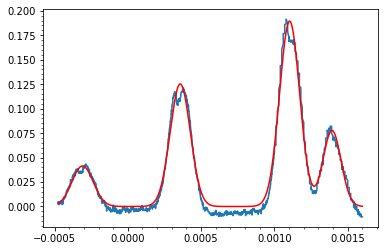

In [68]:
# Now that we have the y-error we can do another fit using that and find our chi-squared

# define functions for Chi squared
def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))



def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

guess = [-0.00030, 0.05000, 0.00020, 0.00030, 0.15000, 0.00020, 0.00110, 0.21000, 0.00020, 0.00135, 0.08000, 0.00020]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=150000)
#print(popt)
fit = func(x, *popt)

i = 0
while i < 12:
    print("Pram(" + str(i) + "): " + str(popt[i]) + " +/- " + str(np.sqrt(pcov[i,i])) )
    i += 1
    
print("")
RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))


plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()

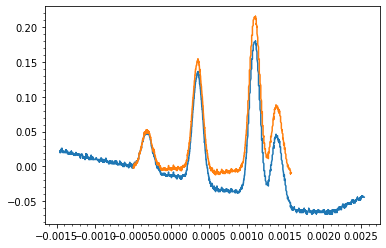

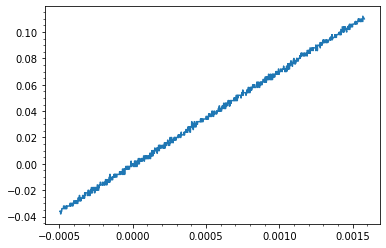

Y-error = (+/-) 0.0016216947220892288

Pram(0): -0.00031649965589272444 +/- 7.783410764536553e-07
Pram(1): 0.05204280110971164 +/- 0.000536939126215933
Pram(2): 9.243332924752745e-05 +/- 1.1038353248579268e-06
Pram(3): 0.00034992633568441367 +/- 2.5888731773699306e-07
Pram(4): 0.153191283010829 +/- 0.0005477301255471967
Pram(5): 8.867962128248772e-05 +/- 3.661219556767849e-07
Pram(6): 0.00109996665584301 +/- 1.8483801348797187e-07
Pram(7): 0.2189953469837204 +/- 0.0005419791785171465
Pram(8): 9.122115995672953e-05 +/- 2.650618044631444e-07
Pram(9): 0.001393092575255616 +/- 4.429096103492902e-07
Pram(10): 0.08874795820651075 +/- 0.0005575675493221338
Pram(11): 8.617383467799723e-05 +/- 6.351468715743078e-07

Reduced Chi Squared = 8.460756743326659


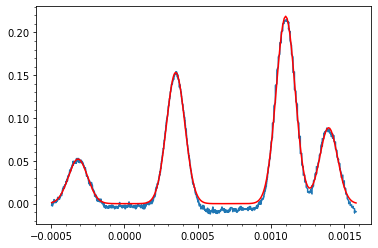

In [71]:
data =  pd.read_csv("A0005CH1.CSV")
data = np.array(data)
x,y = np.split(data, [-1], 1) # Divide into x and y for curve fitting
x.flatten() 
y.flatten()
x = np.hstack(x) # Fix stupid 2d array crap
y = np.hstack(y)

x = x[963:3036]
y = y[963:3036]
rampdata = pd.read_csv("A0005CH2.CSV")
rampdata = np.array(rampdata)
rampx, rampy = np.split(rampdata, [-1], 1)
rampx.flatten()
rampy.flatten()
rampx = np.hstack(rampx)
rampy = np.hstack(rampy)
rampx = rampx[963:3036]
rampy = rampy[963:3036]
y = y + 0.333333333*rampy + 0.01
plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.minorticks_on()
plt.show()

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

guess = [-0.00030, 0.05000, 0.00020, 0.00030, 0.15000, 0.00020, 0.00110, 0.21000, 0.00020, 0.00135, 0.08000, 0.00020]
# position, amplitude, width

################################################ Y Error Analisis
# Find flat '0' segments "manually"
# Automaticly cuts out the portion from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == -0.0001:
        t1 = j
    if i == 0.0001:
        t2 = j
    j += 1
    
x_flat = x[t1:t2]
y_flat = y[t1:t2]

Back_guess = [7,-.004]

def linfunc(x_pts, a, b):
    return a * x_pts + b

Back_popt, Back_pcov = optimize.curve_fit(linfunc, x_flat, y_flat, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_flat - linfunc(x_flat, *Back_guess))**2 ) / (np.size(x_flat) - 2) )

print("Y-error = (+/-) " + str(V_error))
print("")

V_errorA = V_error * np.linspace(1,1,np.size(x))

#plt.plot(x_flat,y_flat)
#plt.plot(x_flat, linfunc(x_flat, *Back_guess))
#plt.show()

################################################



popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=10000)
#print(popt)
fit = func(x, *popt)
#chi2 = np.sum((y - fit)**2/y)
#print(chi2)

i = 0
while i < 12:
    print("Pram(" + str(i) + "): " + str(popt[i]) + " +/- " + str(np.sqrt(pcov[i,i])) )
    i += 1
    
print("")
RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()

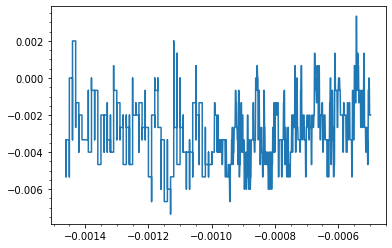

In [70]:
data =  pd.read_csv("A0005CH1.CSV")
data = np.array(data)
x,y = np.split(data, [-1], 1) # Divide into x and y for curve fitting
x.flatten() 
y.flatten()
x = np.hstack(x) # Fix stupid 2d array crap
y = np.hstack(y)
x = x[0:962]
y = y[0:962]
rampdata = pd.read_csv("A0005CH2.CSV")
rampdata = np.array(rampdata)
rampx, rampy = np.split(rampdata, [-1], 1)
rampx.flatten()
rampy.flatten()
rampx = np.hstack(rampx)
rampy = np.hstack(rampy)
rampx = rampx[0:962]
rampy = rampy[0:962]
y = y + 0.333333333*rampy + 0.01
plt.plot(x, y)
plt.minorticks_on()
plt.show()
